In [1]:
# %matplotlib widget
%matplotlib inline
import os
import io
import re
import pickle
import base64
import gridfs
import pymongo
import numpy as np
import pandas as pd
from PIL import Image
from pprint import pprint
from pymongo import MongoClient
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
from IPython.display import HTML
from collections import OrderedDict
import matplotlib.widgets as widgets
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

Using matplotlib backend: Qt5Agg


In [2]:
# Conenct to the client
client = MongoClient('localhost', 27017)

# List databases, collections, and select from them

In [3]:
print('databases:', client.list_database_names())

databases: ['MY_DB', 'admin', 'config', 'local']


In [4]:
db = client['MY_DB']
print('Collections of {} db: {}'.format(db.name, db.list_collection_names()))

Collections of MY_DB db: ['runs', 'omniboard.columns', 'fs.files', 'metrics', 'fs.chunks']


# Get a dataframe that summarize the experiements

In [5]:
def slice_dict(d, keys):
    """ Returns a dictionary ordered and sliced by given keys
        keys can be a list, or a CSV string
    """
    if isinstance(keys, str):
        keys = keys[:-1] if keys[-1] == ',' else keys
        keys = re.split(', |[, ]', keys)

    return dict((k, d[k]) for k in keys)

def sacred_to_df(db_runs, mongo_query=None, ):
    """
    db_runs is usually db.runs
    returns a dataframe that summarizes the experiments, where 
    config and info fields are flattened to their keys.
    Summary DF contains the following columns:
    _id, experiment.name, **config, result, **info, status, start_time
    """
    # get all experiment according to mongo query and represent as pandas DataFrame    
    df = pd.DataFrame(list(db_runs.find(mongo_query)))

    # Take only the interesting columns
    df = df.loc[:, '_id, experiment, config, result, info, status, start_time'.split(', ')]

    def _summerize_experiment(s):
        """
        Take only the 
        """
        o = OrderedDict()
        o['_id'] = s['_id']
        o['name'] = s['experiment']['name']
        o.update(s['config'])
        for key, val in s['info'].items():
            if key != 'metrics':
                o[key] = val 

        o.update(slice_dict(s.to_dict(), 'info, status'))
        return pd.Series(o)
    
    sum_list = []
    for ix, s in df.iterrows():
        sum_list.append(_summerize_experiment(s))
    df_summary = pd.DataFrame(sum_list).set_index('_id')
    
    return df_summary

# Filter according to some query

In [6]:
# Get the COMPLETED experiments
query = "status == 'COMPLETED'"
df_summary = sacred_to_df(db.runs)
# Fix column names
df_summary.columns = df_summary.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_summary.columns = df_summary.columns.str.replace('.', '_')
# Now execute the query
df_summary.query(query)
# Sort them in ascending order based on validation loss (best performer is first).
df_summary = df_summary.sort_values('best_valid_loss', ascending=True)
display(df_summary.head())

,name,default_params,seed,best_valid_loss,ckpt,info,status
_id,,,,,,,
43,circles_scatter_weights_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",196231595,2.070855e-07,./models//circles/scatter_weights/epoch_499_lo...,"{'best.valid.loss': 2.070855202873645e-07, 'ck...",COMPLETED
60,moons_vanilla_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",547989329,2.537913e-07,./models//moons/vanilla/epoch_499_loss_[0. 0. ...,"{'best.valid.loss': 2.537913132982794e-07, 'ck...",COMPLETED
41,circles_vanilla_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",783968949,3.607927e-07,./models//circles/vanilla/epoch_434_loss_[0. 0...,"{'best.valid.loss': 3.6079273968425696e-07, 'c...",COMPLETED
62,moons_scatter_weights_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",964110128,1.508898e-06,./models//moons/scatter_weights/epoch_499_loss...,"{'best.valid.loss': 1.508897867097403e-06, 'ck...",COMPLETED
44,circles_scatter_embedding_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",10716314,2.795730e-05,./models//circles/scatter_embedding/epoch_497_...,"{'best.valid.loss': 2.795730142679531e-05, 'ck...",COMPLETED


# Get raw experiments, according to the summary dataframe

In [7]:
def query_by_df(mongo_db_runs, df=None, ids=None):
    """
    Get raw experiments, according to the summary dataframe, or list of ids
    """
    if ids is None:
        ids = df.index.tolist()
        
    # Get a mongo iterator, according to the pandas DataFrame. 
    mongo_cursor = mongo_db_runs.find(dict(_id={'$in':ids}))
    
    # put raw results to a datafram
    df_raw_results = pd.DataFrame(list(mongo_cursor)).set_index('_id')
    
    # reorder results according to given dataframe because Cursor iterator does not preserve order from given dataframe 
    df_raw_results = df_raw_results.reindex(ids)
    return df_raw_results

df_raw = query_by_df(db.runs, df_summary)
df_raw.head()

,artifacts,captured_out,command,config,experiment,format,heartbeat,host,info,meta,resources,result,start_time,status,stop_time
_id,,,,,,,,,,,,,,,
43,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_scatter_weights_AdamOptimizer -...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'circles_scatter_weights_AdamOptimize...,MongoObserver-0.7.0,2019-02-23 22:46:32.196,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.070855202873645e-07, 'ck...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:43:10.285,COMPLETED,2019-02-23 22:46:32.174
60,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_vanilla_AdamOptimizer - Running c...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'moons_vanilla_AdamOptimizer', 'base_...",MongoObserver-0.7.0,2019-02-24 22:26:23.779,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.537913132982794e-07, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:23:02.012,COMPLETED,2019-02-24 22:26:23.760
41,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_vanilla_AdamOptimizer - Running...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'circles_vanilla_AdamOptimizer', 'bas...",MongoObserver-0.7.0,2019-02-23 22:39:47.637,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 3.6079273968425696e-07, 'c...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:36:31.030,COMPLETED,2019-02-23 22:39:47.619
62,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_scatter_weights_AdamOptimizer - R...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'moons_scatter_weights_AdamOptimizer'...,MongoObserver-0.7.0,2019-02-24 22:33:03.699,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 1.508897867097403e-06, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:29:47.945,COMPLETED,2019-02-24 22:33:03.677
44,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_scatter_embedding_AdamOptimizer...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'circles_scatter_embedding_AdamOptimi...,MongoObserver-0.7.0,2019-02-23 22:49:43.249,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.795730142679531e-05, 'ck...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:46:32.711,COMPLETED,2019-02-23 22:49:43.228


# Do we get better models in terms of perfomance metrics?

In [58]:
from bson.objectid import ObjectId

# For disp. imgs in DataFrame
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with io.BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/png;base64,{image_base64(im)}">'

def fig2pngbuf(fig):
#     buffer = StringIO.StringIO()
    buffer = io.BytesIO()
#     canvas = plt.get_current_fig_manager().canvas
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buffer.shape = (w, h)
    image = Image.frombytes(
        'RGB',
        (w, h),
        fig.canvas.tostring_rgb()
    )
    image.save(buffer, 'PNG')
    return buffer
    
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf

def fig2img(fig):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
#     buf = fig2data(fig)
    buf = fig2pngbuf(fig)
#     w, h, d = buf.shape
#     return Image.frombytes("RGBA", (w, h), buf.tostring())
    return Image.open(buf)

def metrics_to_name_id_dict(list_metrics):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for metric in list_metrics:
        metric_name = metric['name']
        if metric_name in d.keys():
            raise(RuntimeError('%s metric has duplicates' % metric_name))
        d[metric_name] = ObjectId(metric['id'])
    return d

def experiment_metrics(db, exp_id):
    ex = db.runs.find_one(dict(_id=exp_id))
    metrics_id = metrics_to_name_id_dict(ex['info']['metrics'])
    metrics = {}
    for metric, id in metrics_id.items():        
        metrics[metric] = db.metrics.find_one(dict(_id=id))
    return metrics
    
def plot_experiment_metrics(db, exp_id, metrics_to_plot=None, rename_metrics={}):
    metrics = experiment_metrics(db, exp_id)
    if metrics_to_plot is None:
        metrics_to_plot = sorted(list(metrics.keys()))
    
    legend = []
    for name in metrics_to_plot:
        plt.plot(metrics[name]['steps'], metrics[name]['values'])
        # rename the metric if a new name is given
        legend.append(rename_metrics.get(name, name))
    return legend

def summarize_metrics(df_summarized):
    d_metrics = {
        ('Accuracy','train'): [], 
        ('Accuracy','valid'): [], 
        ('Accuracy','test'): [],
        ('Loss','train'): [], 
        ('Loss','valid'): []
    }
    d_plots = {
        'Model': [],
        'Train_Metrics': [],
        'Valid_Metrics': [],
        'Test_Metrics': []
    }
    exper_names = []
    for idx, name in enumerate(df_summarized['name']):
        exper_names.append(name)
        d_plots['Model'].append(name)
        metrics = experiment_metrics(db, int(df_summarized.index[idx]))
        d_metrics[('Accuracy','train')].append(np.max(metrics['training.acc']['values']))
        d_metrics[('Accuracy','valid')].append(np.max(metrics['validation.acc']['values']))
        d_metrics[('Accuracy','test')].append(np.max(metrics['test.accuracy']['values']))
        d_metrics[('Loss','train')].append(np.min(metrics['training.loss']['values']))
        d_metrics[('Loss','valid')].append(np.min(metrics['validation.loss']['values']))
        for mode in ['train', 'valid', 'test']:
            metric_name = 'training' if mode is 'train' else 'validation'
            plt.ioff()
            fig = plt.figure()
            if mode is 'test':
                legend = plot_experiment_metrics(
                    db, 
                    int(df_summary.index[idx]), 
                    ['test.accuracy'],
                    rename_metrics={'test.accuracy': 'Test Accuracy'}
                )
            else:
                legend = plot_experiment_metrics(
                    db, 
                    int(df_summarized.index[idx]),
                    [metric_name + '.acc', metric_name + '.loss', metric_name + '.error'],
                    rename_metrics={metric_name + '.acc': 'Train Accuracy',
                                    metric_name + '.loss': 'Training Loss',
                                    metric_name + '.error': 'MSE on labels'}
                )
            plt.legend(legend);
            plt.xlabel('Epoch')
            plt.ylabel('Values')
            plt.title(name)
            plt.grid(True)
            d_plots[mode.capitalize() + '_Metrics'].append(fig2img(fig))
            plt.close('all')
    df_metrics = pd.DataFrame(d_metrics, index=exper_names)
    df_plots = pd.DataFrame(d_plots)
    return df_metrics, df_plots

In [59]:
metrics, plots = summarize_metrics(df_summary)

# Metrics across model and dataset combination

In [71]:
with open('metrics.pickle', 'wb') as fh:
    pickle.dump(metrics, fh)
with open('metrics_plots.pickle', 'wb') as fh:
    pickle.dump(plots, fh)

In [61]:
display(metrics)

Accuracy                      \
                                                  train     valid      test   
circles_scatter_weights_AdamOptimizer          0.998986  1.000000  1.000000   
moons_vanilla_AdamOptimizer                    0.998033  1.000000  1.000000   
circles_vanilla_AdamOptimizer                  0.998977  1.000000  1.000000   
moons_scatter_weights_AdamOptimizer            0.998102  1.000000  1.000000   
circles_scatter_embedding_AdamOptimizer        0.995984  1.000000  1.000000   
moons_scatter_embedding_AdamOptimizer          0.989031  1.000000  1.000000   
circles_l2_AdamOptimizer                       0.999026  1.000000  1.000000   
moons_l2_AdamOptimizer                         0.996325  1.000000  1.000000   
swiss_roll_scatter_weights_AdamOptimizer       0.998336  0.999674  0.997070   
swiss_roll_l2_AdamOptimizer                    0.998150  0.999457  0.999674   
swiss_roll_vanilla_AdamOptimizer               0.998364  0.999783  0.999674   
swiss_roll_scatter_embedding_AdamOptimizer     0.995791  0.999457  0.998481   
mnist_convnet_AdamOptimizer                    0.990039  0.987088  0.989583   
mnist_scatter_embedding_AdamOptimizer          0.992356  0.980360  0.979492   
mnist_l2_AdamOptimizer                         0.998301  0.983398  0.982205   
mnist_scatter_weights_AdamOptimizer            0.998884  0.982530  0.981337   
mnist_vanilla_AdamOptimizer                    0.998796  0.981662  0.980794   
fashion_mnist_convnet_AdamOptimizer            0.946888  0.898763  0.885417   
fashion_mnist_l2_AdamOptimizer                 0.983699  0.898763  0.891602   
fashion_mnist_scatter_embedding_AdamOptimizer  0.955259  0.895725  0.891168   
fashion_mnist_scatter_weights_AdamOptimizer    0.985332  0.898112  0.894640   
fashion_mnist_vanilla_AdamOptimizer            0.985761  0.896918  0.895399   
cifar10_convnet_AdamOptimizer                  0.804410  0.614041  0.611871   
cifar10_scatter_embedding_AdamOptimizer        0.747211  0.527452  0.514323   
cifar10_l2_AdamOptimizer                       0.891179  0.546224  0.518989   
cifar10_scatter_weights_AdamOptimizer          0.885870  0.538520  0.531684   
cifar10_vanilla_AdamOptimizer                  0.888272  0.538303  0.518663   

                                                   Loss                
                                                  train         valid  
circles_scatter_weights_AdamOptimizer          0.002401  2.070855e-07  
moons_vanilla_AdamOptimizer                    0.004539  4.574413e-08  
circles_vanilla_AdamOptimizer                  0.002400  8.690010e-08  
moons_scatter_weights_AdamOptimizer            0.004386  1.065258e-07  
circles_scatter_embedding_AdamOptimizer        0.010482  1.040085e-05  
moons_scatter_embedding_AdamOptimizer          0.028176  6.272609e-05  
circles_l2_AdamOptimizer                       0.004296  4.522032e-05  
moons_l2_AdamOptimizer                         0.009618  9.250119e-05  
swiss_roll_scatter_weights_AdamOptimizer       0.003528  1.217550e-03  
swiss_roll_l2_AdamOptimizer                    0.007027  1.795869e-03  
swiss_roll_vanilla_AdamOptimizer               0.003460  1.465343e-03  
swiss_roll_scatter_embedding_AdamOptimizer     0.015633  1.871232e-03  
mnist_convnet_AdamOptimizer                    0.064707  5.043621e-02  
mnist_scatter_embedding_AdamOptimizer          0.044691  8.716084e-02  
mnist_l2_AdamOptimizer                         0.012517  8.071576e-02  
mnist_scatter_weights_AdamOptimizer            0.003839  9.070876e-02  
mnist_vanilla_AdamOptimizer                    0.004078  1.005438e-01  
fashion_mnist_convnet_AdamOptimizer            0.191253  3.049413e-01  
fashion_mnist_l2_AdamOptimizer                 0.060134  3.501810e-01  
fashion_mnist_scatter_embedding_AdamOptimizer  0.155967  3.338174e-01  
fashion_mnist_scatter_weights_AdamOptimizer    0.040734  3.083162e-01  
fashion_mnist_vanilla_AdamOptimizer            0.039393  3.142079e-01  
cifar10_convnet_AdamOptimiz

# Plots of the above metrics

,Model,Train_Metrics,Valid_Metrics,Test_Metrics
0,circles_scatter_weights_AdamOptimizer,,,
1,moons_vanilla_AdamOptimizer,,,
2,circles_vanilla_AdamOptimizer,,,
3,moons_scatter_weights_AdamOptimizer,,,
4,circles_scatter_embedding_AdamOptimizer,,,
5,moons_scatter_embedding_AdamOptimizer,,,
6,circles_l2_AdamOptimizer,,,
7,moons_l2_AdamOptimizer,,,
8,swiss_roll_scatter_weights_AdamOptimizer,,,
9,swiss_roll_l2_AdamOptimizer,,,

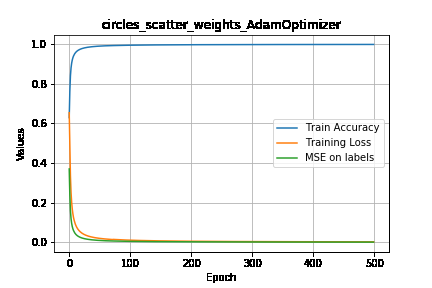
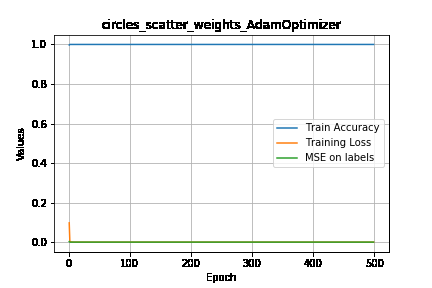
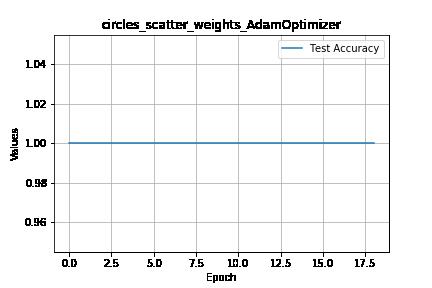
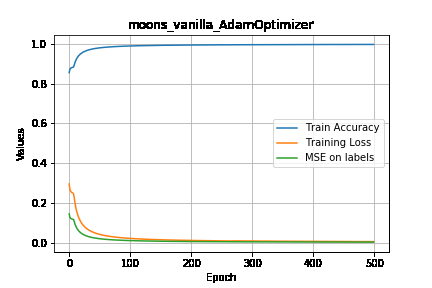
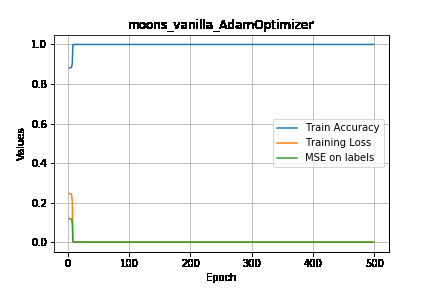
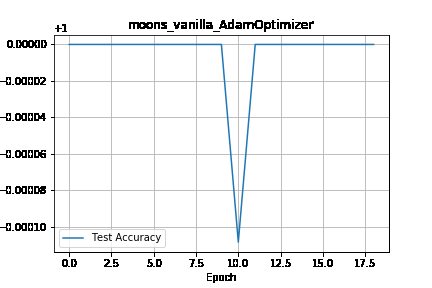
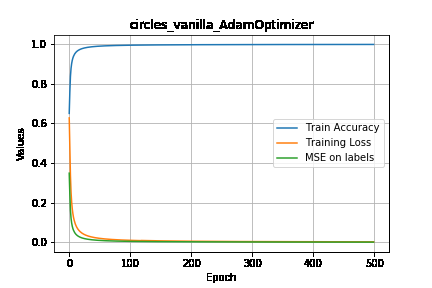
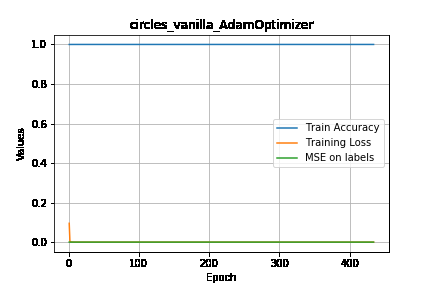
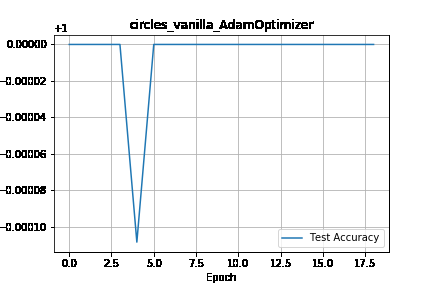
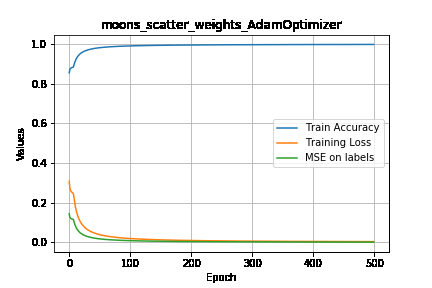
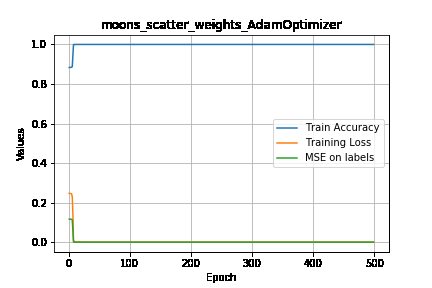
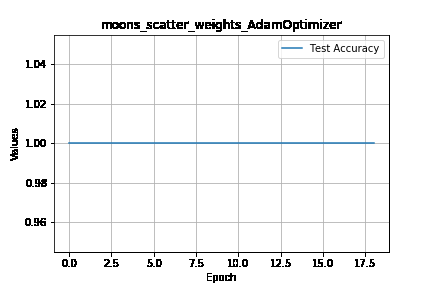
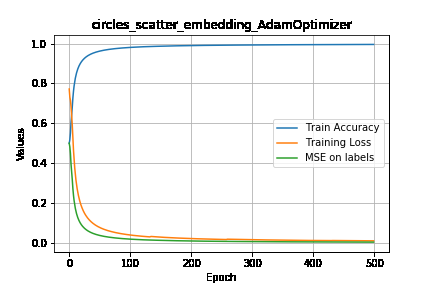
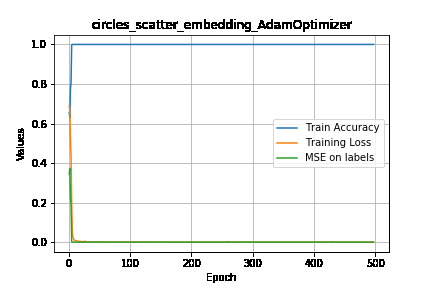
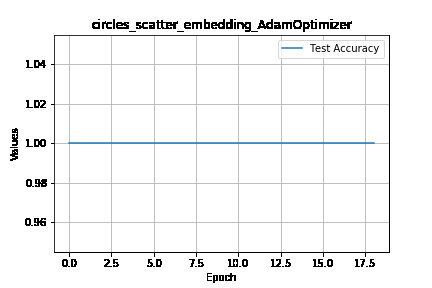
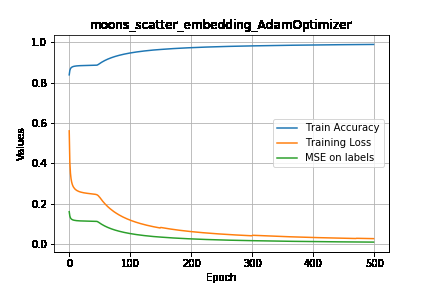
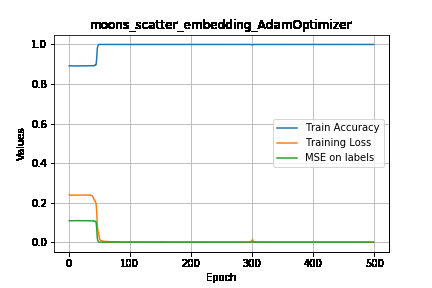
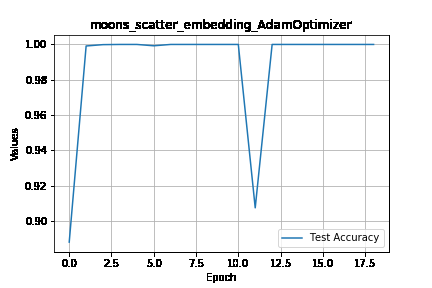
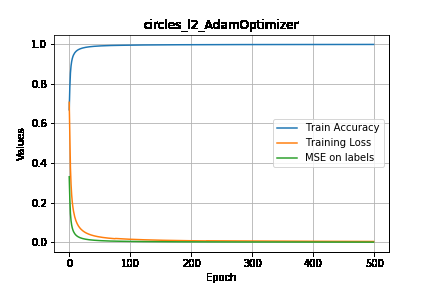
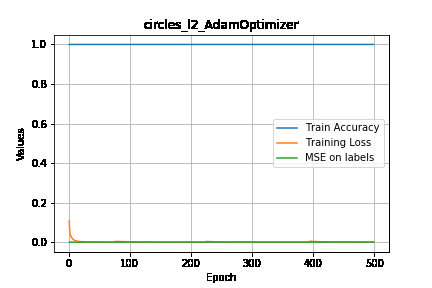
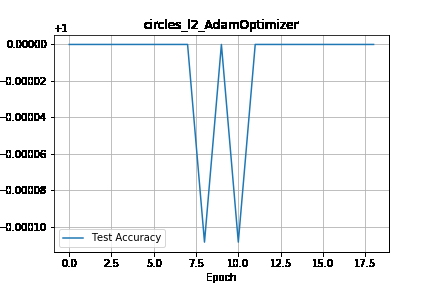
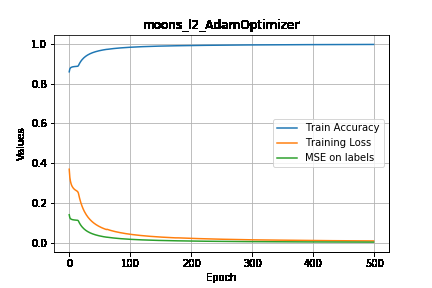
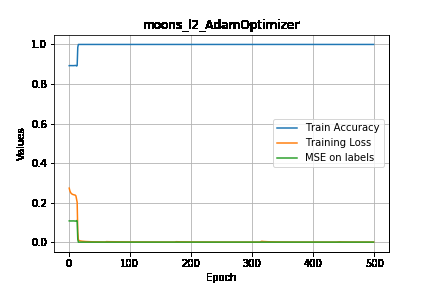
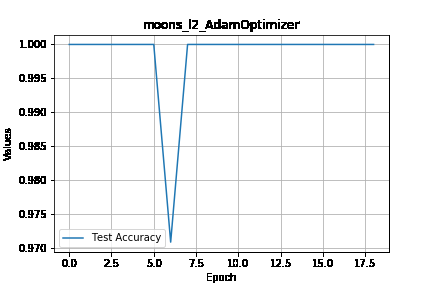
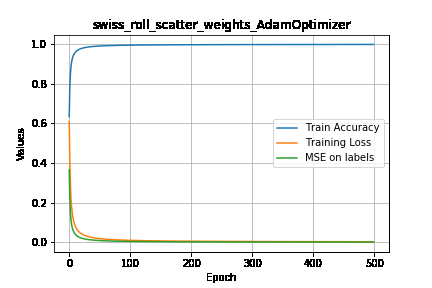
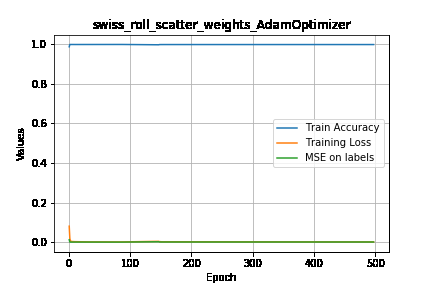
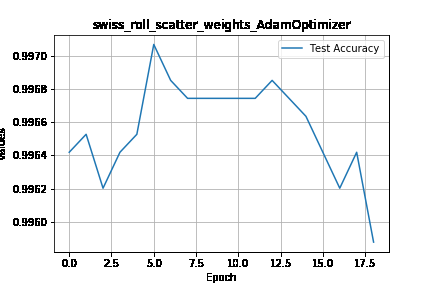
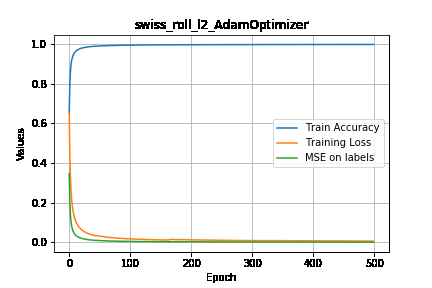
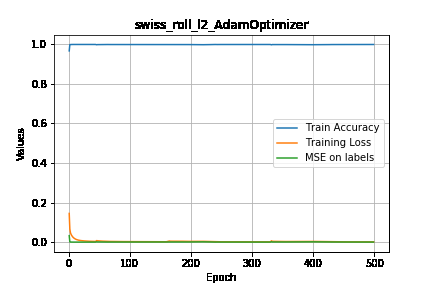
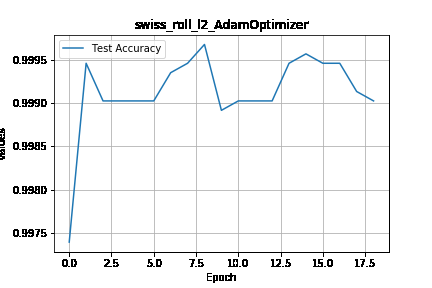
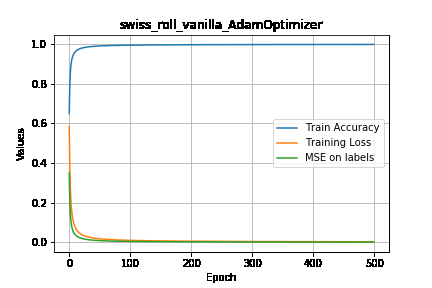
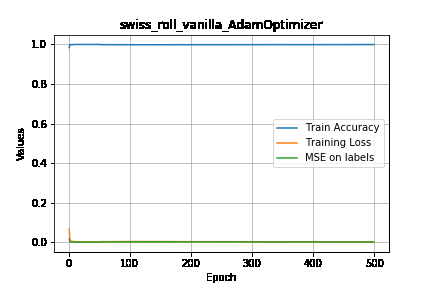
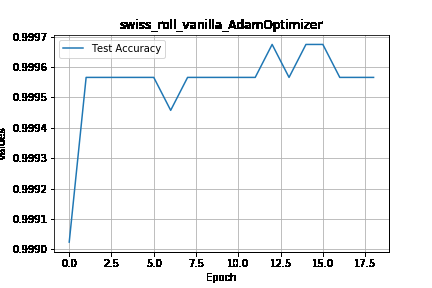
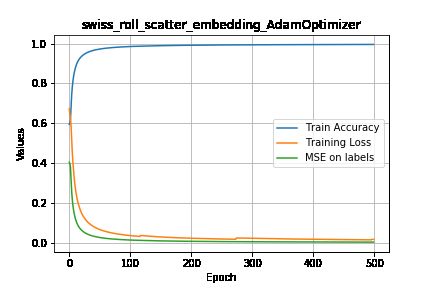
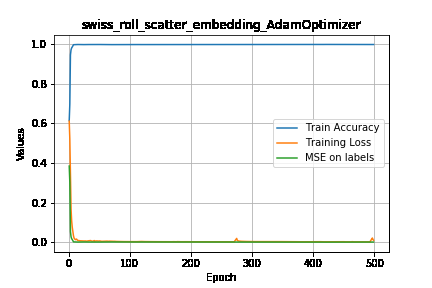
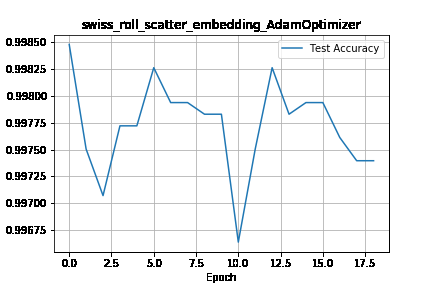
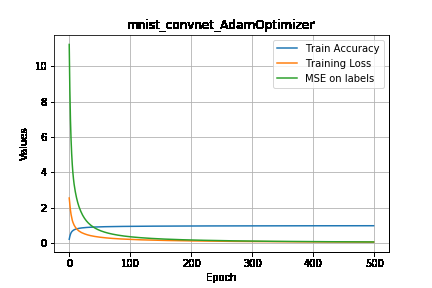
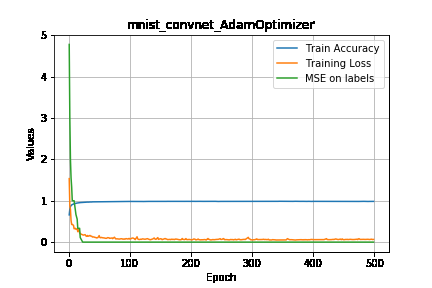
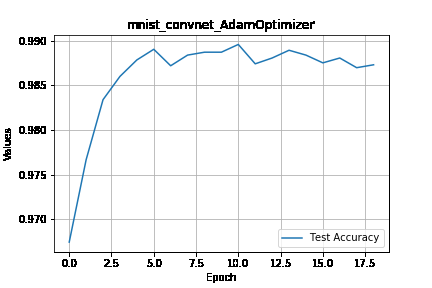
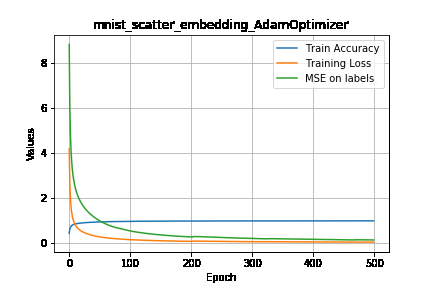
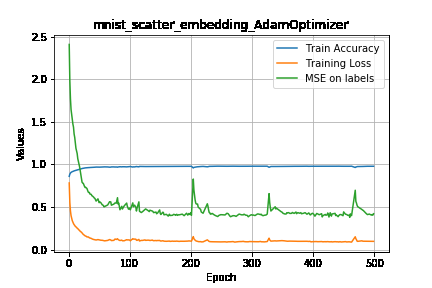
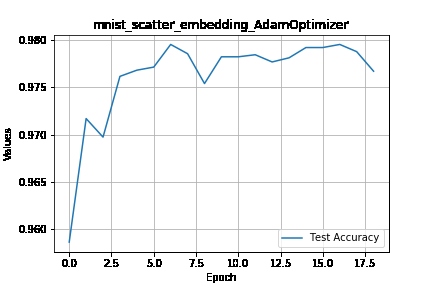
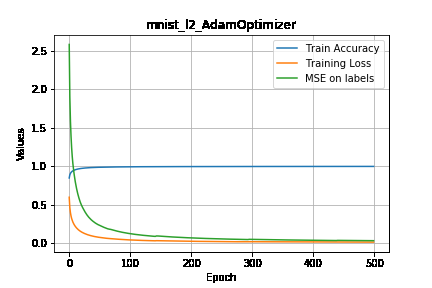
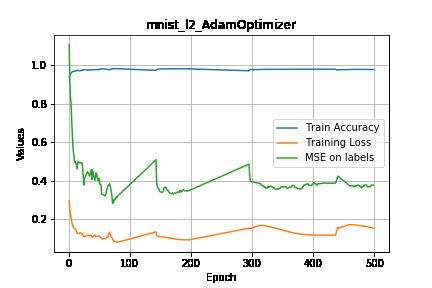
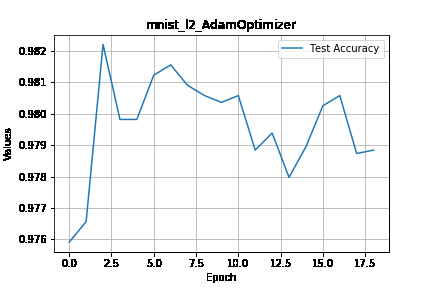
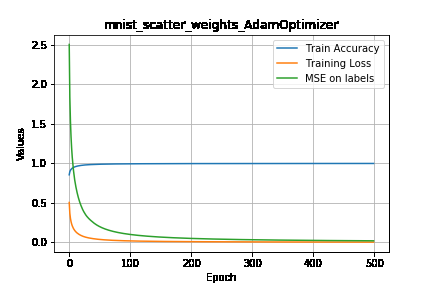
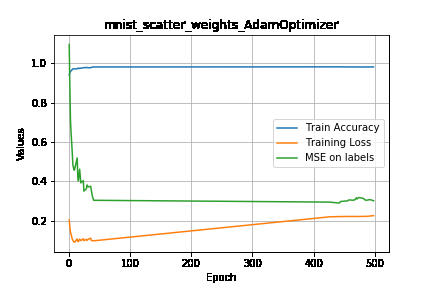
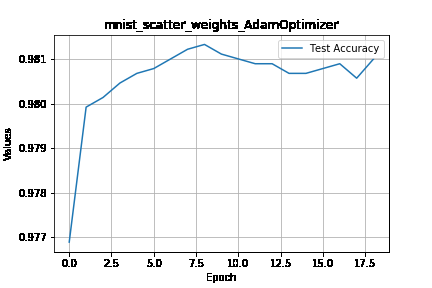
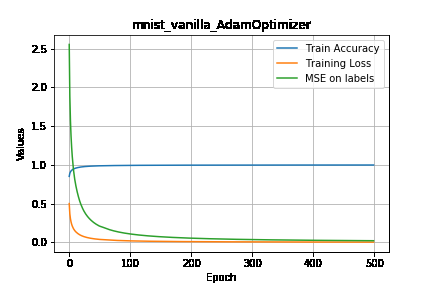
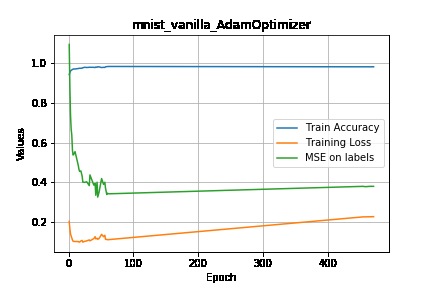
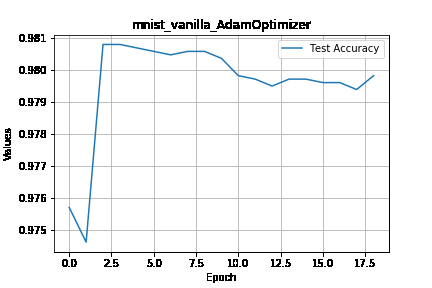
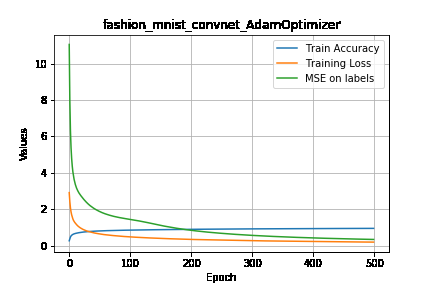
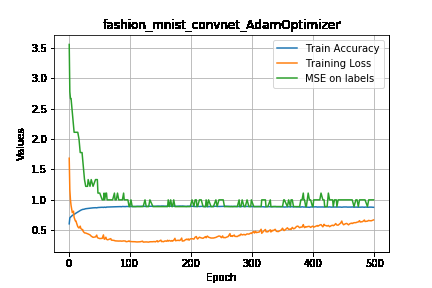
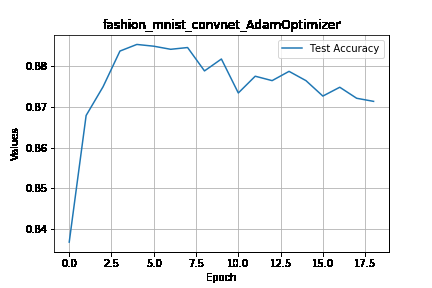
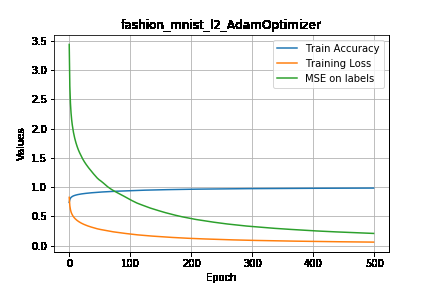
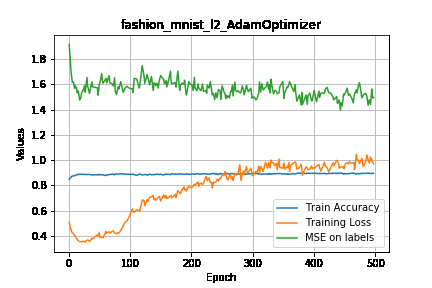
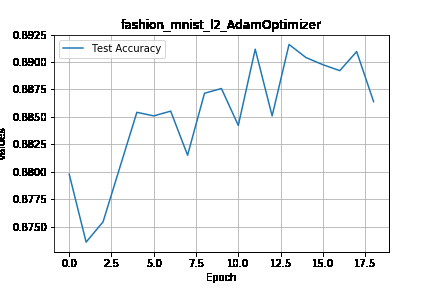
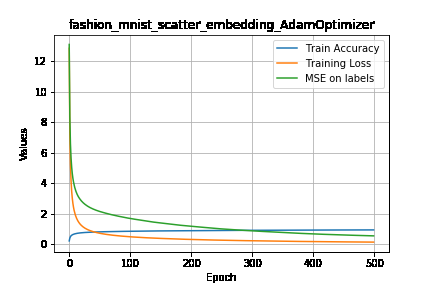
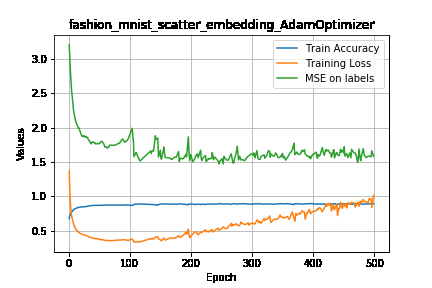
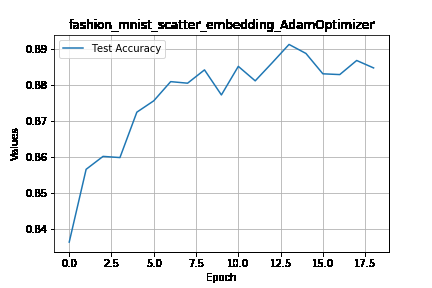
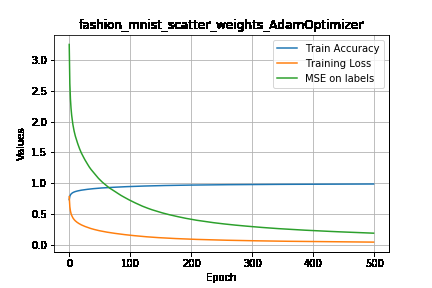
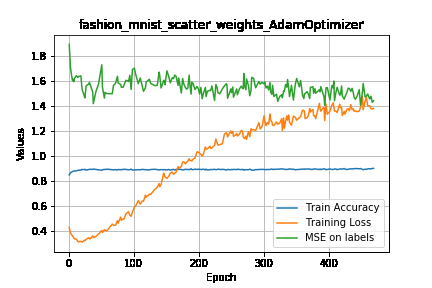
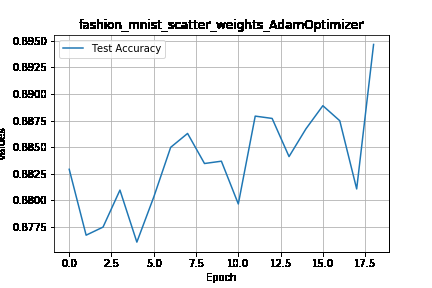
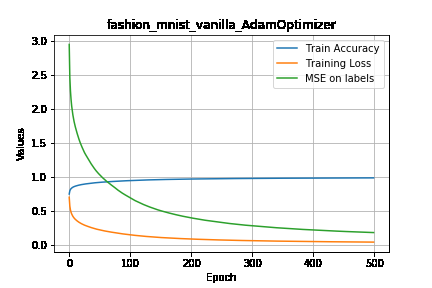
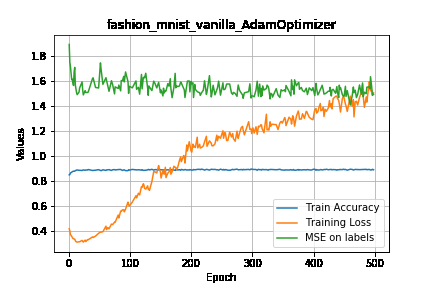
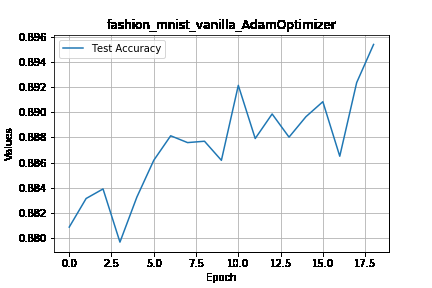
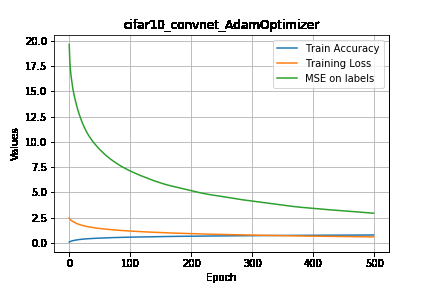
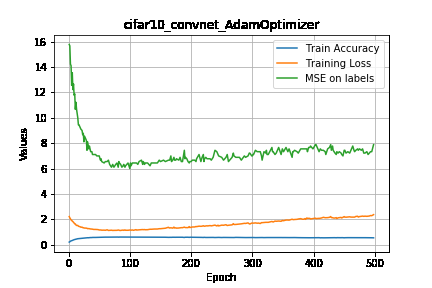
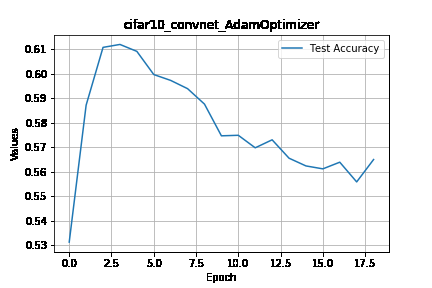
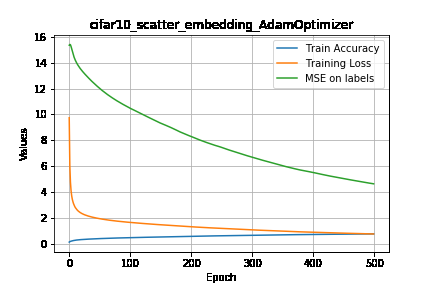
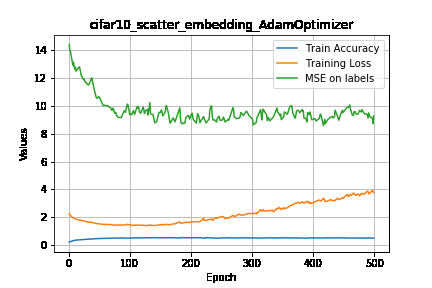
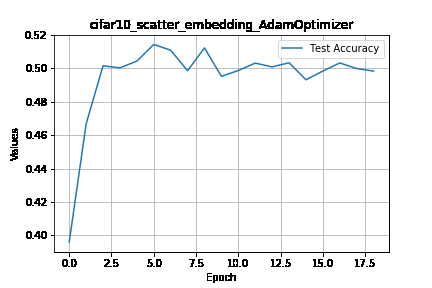
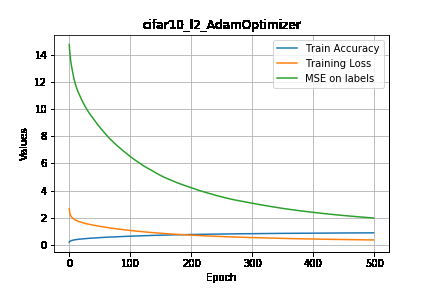
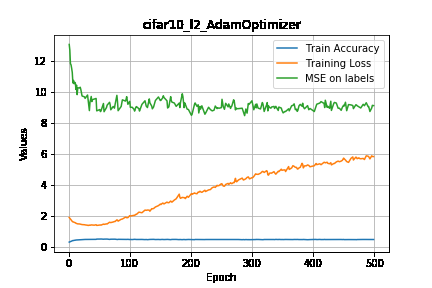
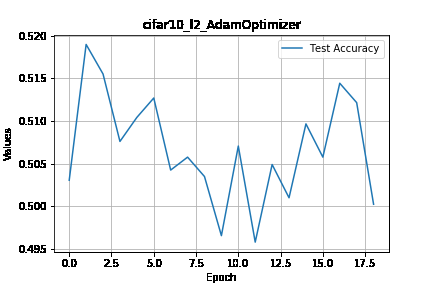
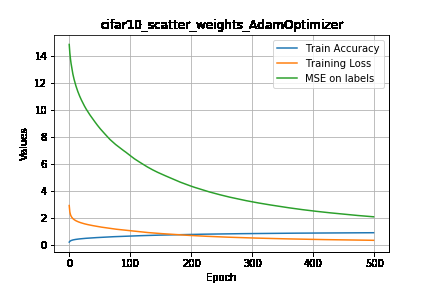
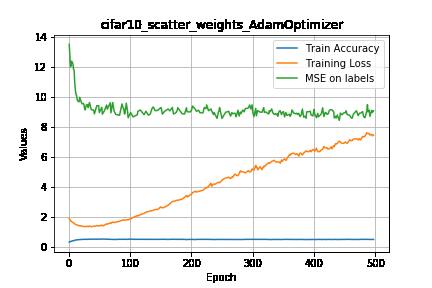
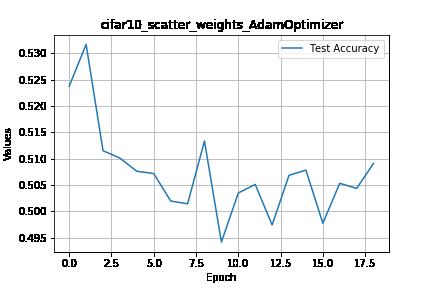
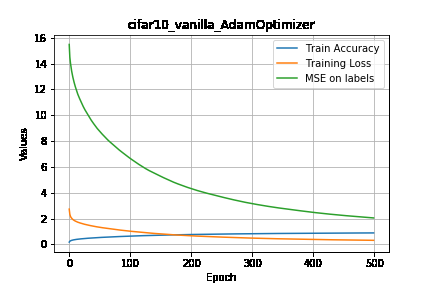
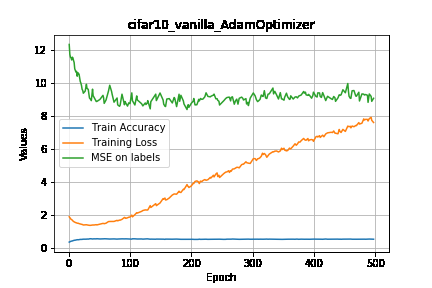
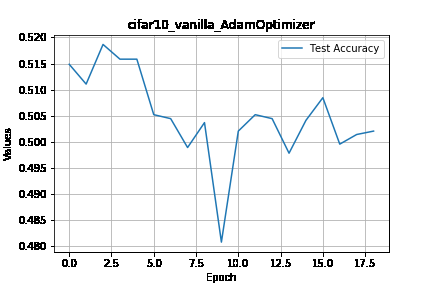

In [60]:
# Show the results for each model and dataset combination
HTML(plots[['Model', 'Train_Metrics', 'Valid_Metrics', 'Test_Metrics']].to_html(formatters={'Train_Metrics': image_formatter, 'Valid_Metrics': image_formatter, 'Test_Metrics': image_formatter}, escape=False))

# Do we get better calibrated models?

In [62]:
# For expers and imgs in DB

fs = gridfs.GridFS(db)

def exp_artifacts_to_dict(list_artifacts):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for ar in list_artifacts:
        if ar['name'] in d.keys():
            d[ar['name']].append(ar['file_id'])
        else:
            d[ar['name']] = []
            d[ar['name']].append(ar['file_id'])
    return d

exper = {'Model': [], 'Before': [], 'After': []}
for idx, ex in enumerate(df_raw.experiment):
    gfs_artifacts = exp_artifacts_to_dict(df_raw.artifacts.iloc[idx])
    imgs_bytes_before = [fs.get(imgObj).read() for imgObj in gfs_artifacts['reliab.png']]
    imgs_bytes_after = [fs.get(imgObj).read() for imgObj in gfs_artifacts['reliab_calib.png']]
    imgs_before = [Image.open(io.BytesIO(img)) for img in imgs_bytes_before]
    imgs_after = [Image.open(io.BytesIO(img)) for img in imgs_bytes_after]
    exper['Model'].append(ex['name'])
    exper['Before'].append(imgs_before)
    exper['After'].append(imgs_after)
exper['Before'] = sum(exper['Before'], [])  # flatten nested lists
exper['After'] = sum(exper['After'], [])

df_calibrated = pd.DataFrame(exper)

In [74]:
with open('calibration_plots.pickle', 'wb') as fh:
    pickle.dump(df_calibrated, fh)

,Model,Before,After
0,circles_scatter_weights_AdamOptimizer,,
1,moons_vanilla_AdamOptimizer,,
2,circles_vanilla_AdamOptimizer,,
3,moons_scatter_weights_AdamOptimizer,,
4,circles_scatter_embedding_AdamOptimizer,,
5,moons_scatter_embedding_AdamOptimizer,,
6,circles_l2_AdamOptimizer,,
7,moons_l2_AdamOptimizer,,
8,swiss_roll_scatter_weights_AdamOptimizer,,
9,swiss_roll_l2_AdamOptimizer,,

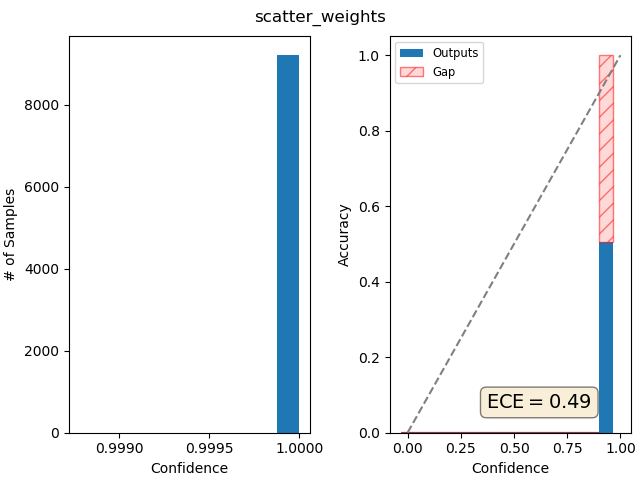
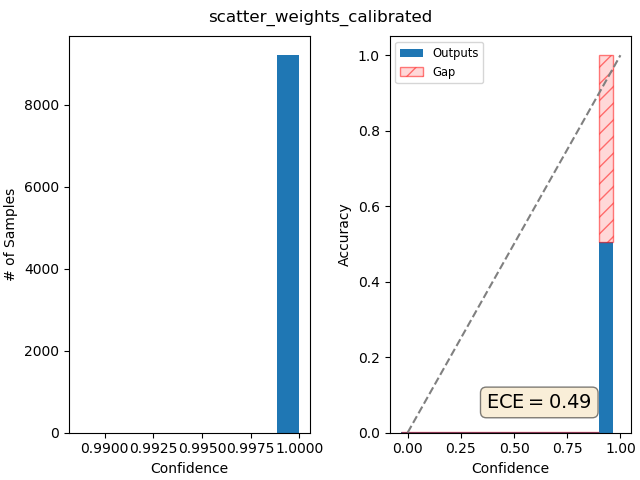
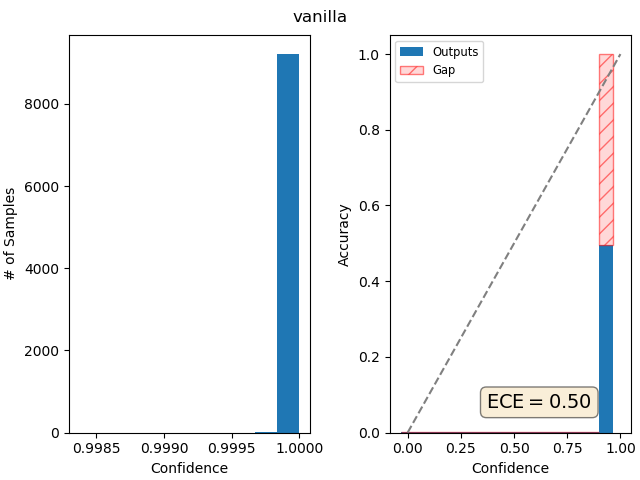
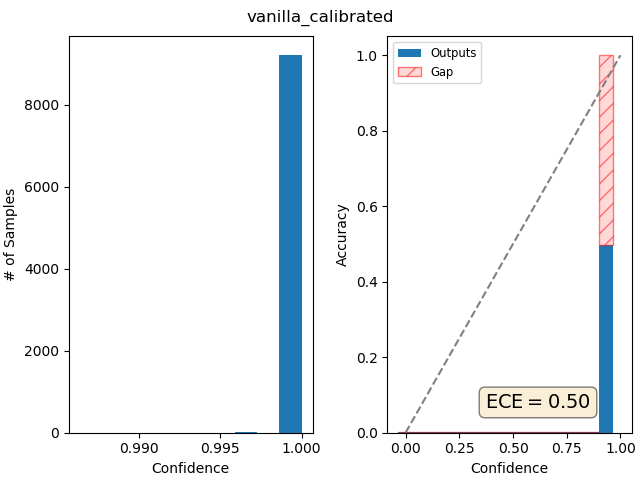
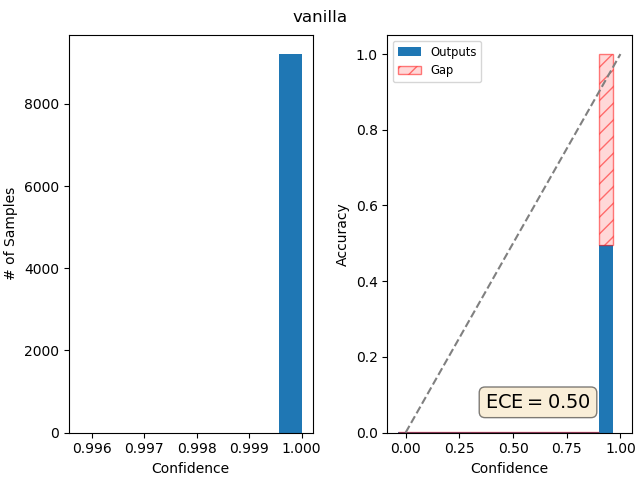
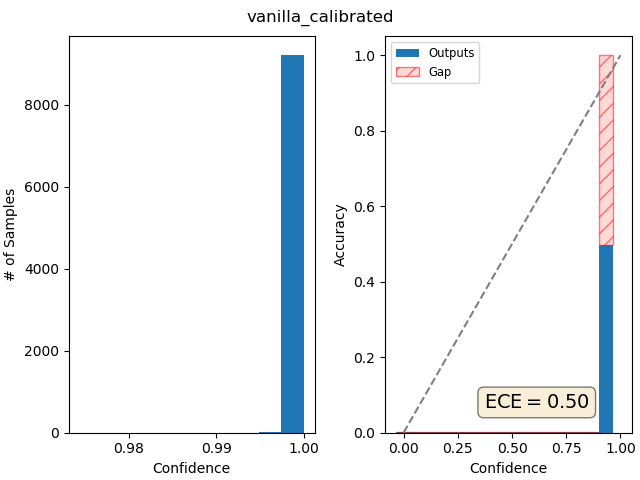
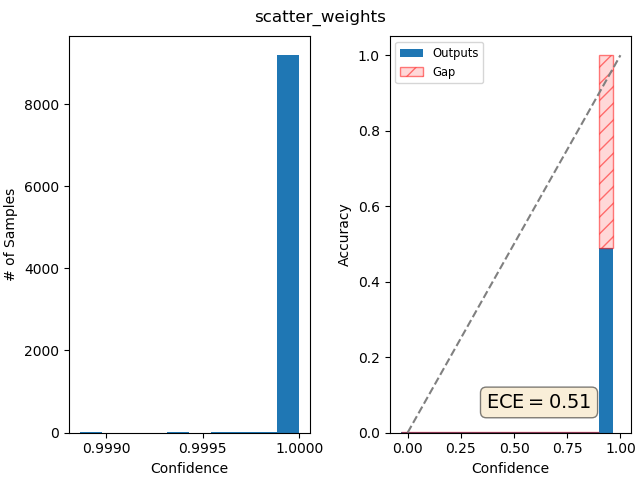
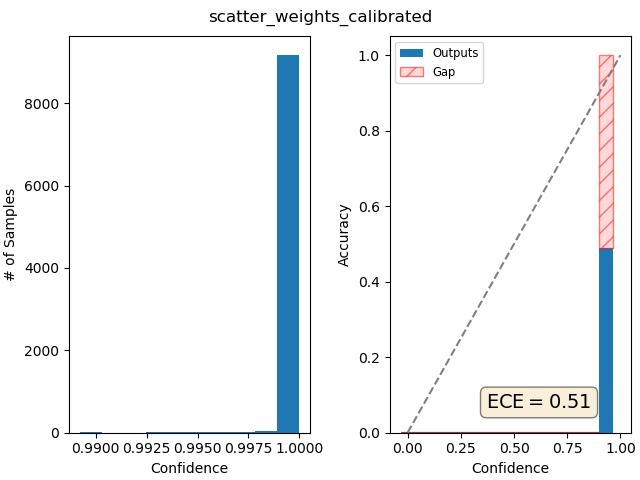
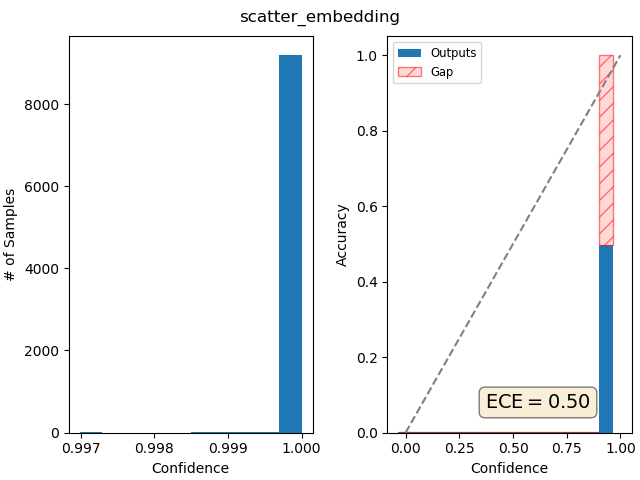
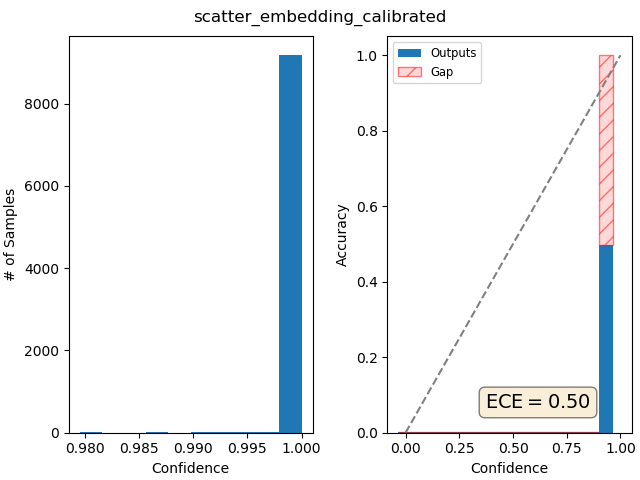
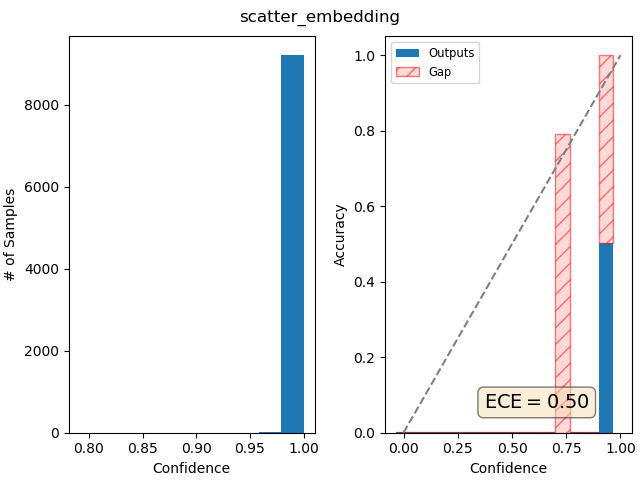
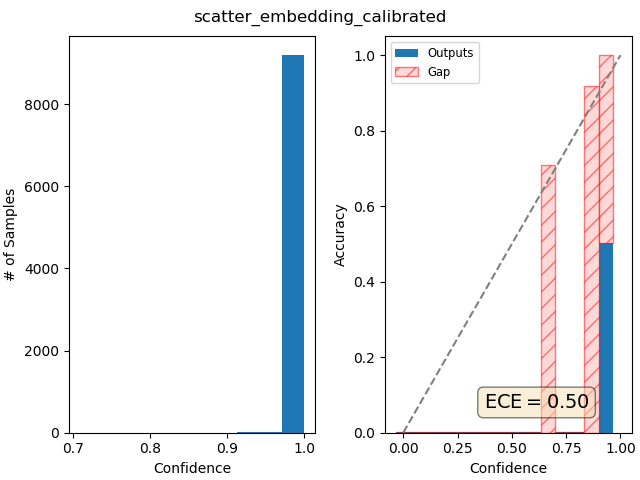
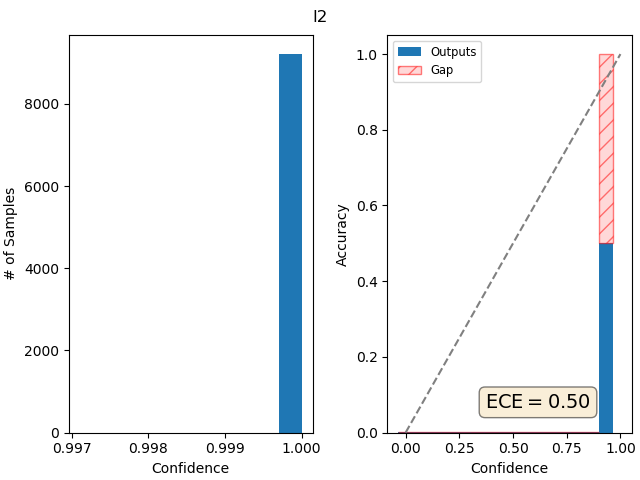
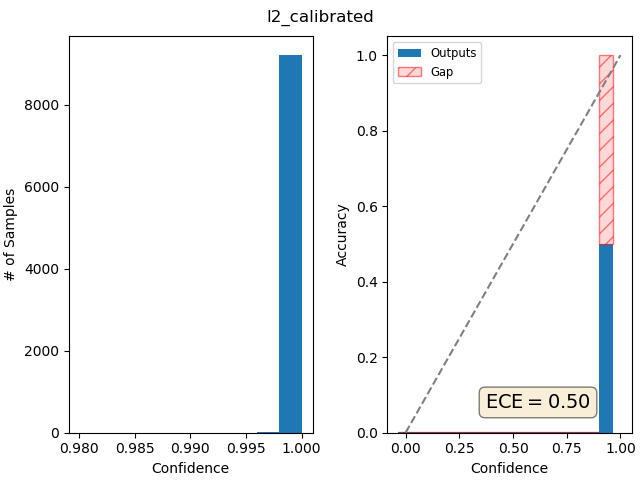
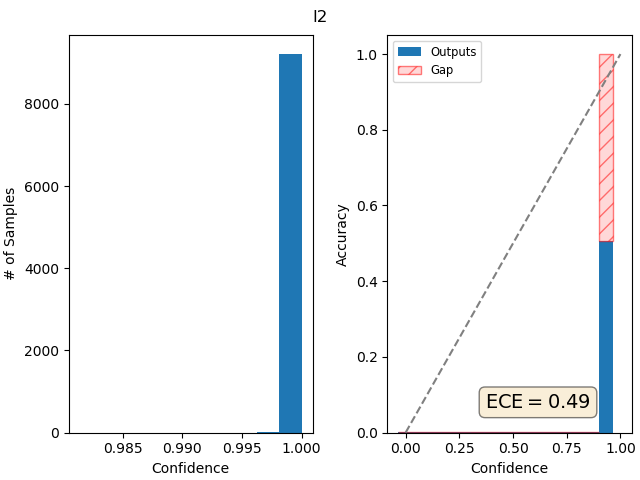
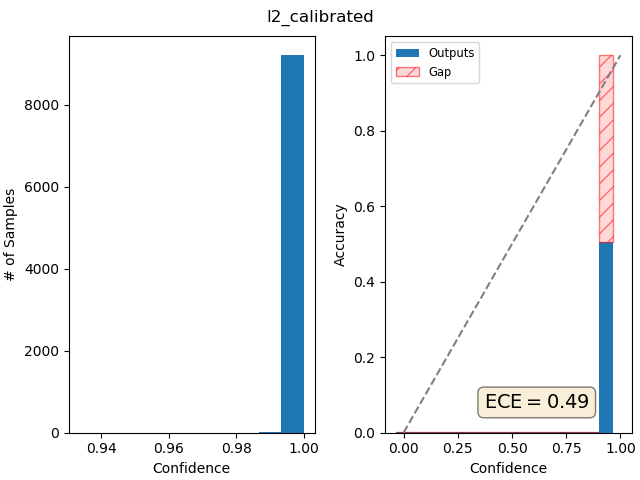
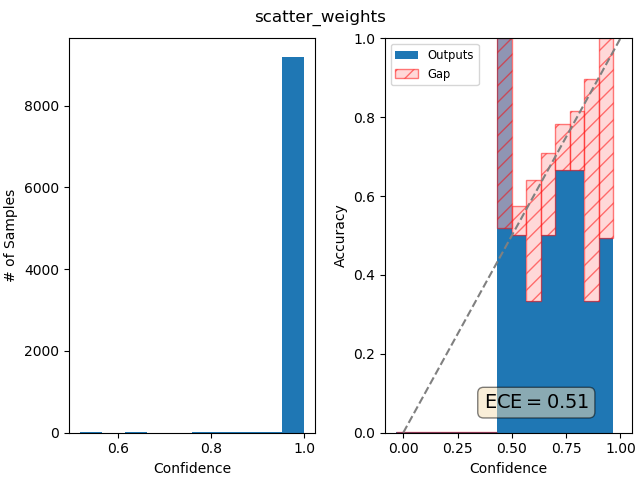
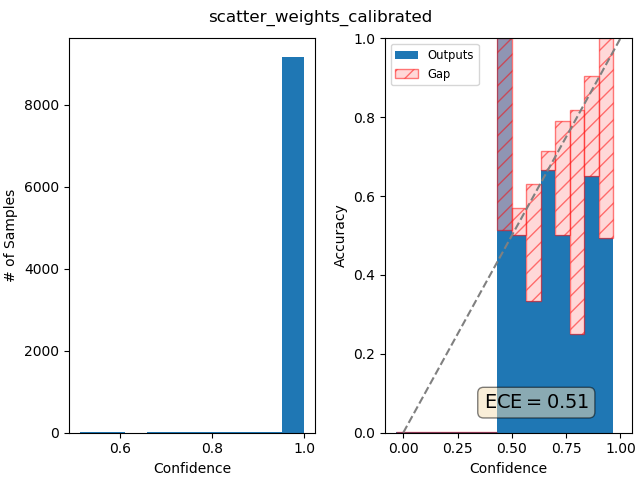
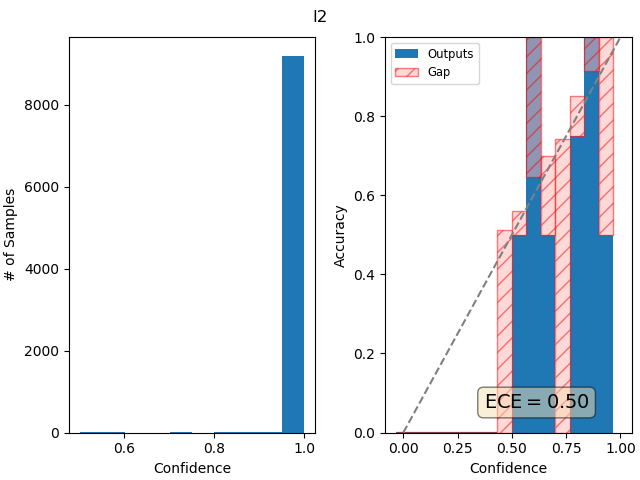
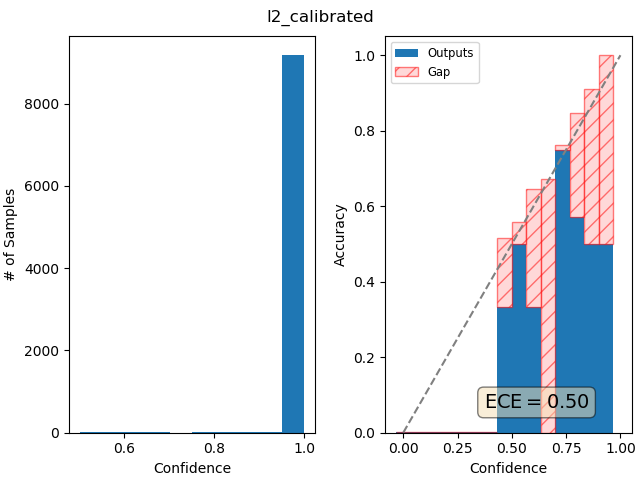
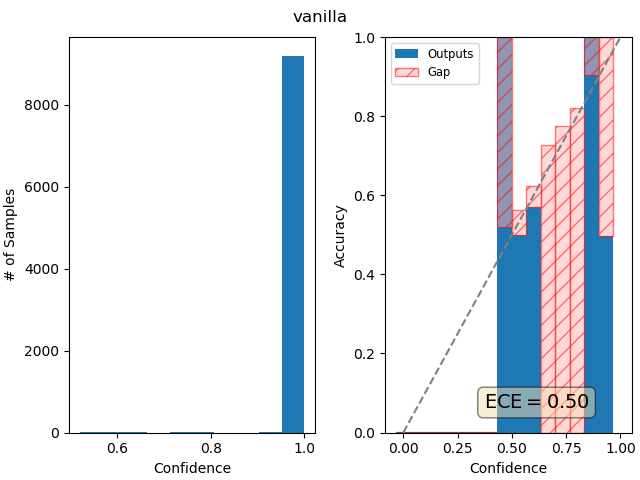
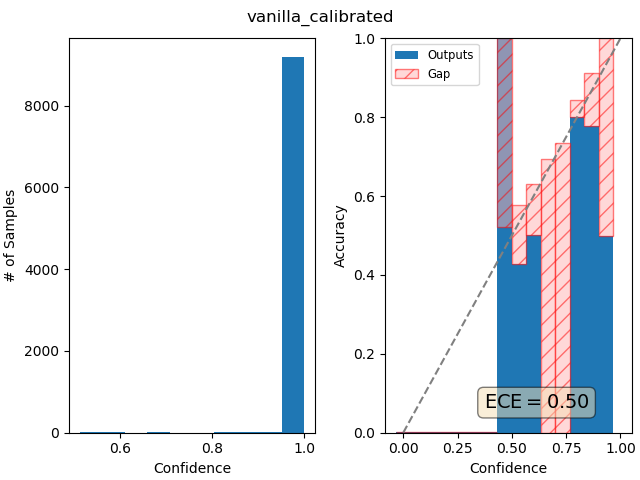
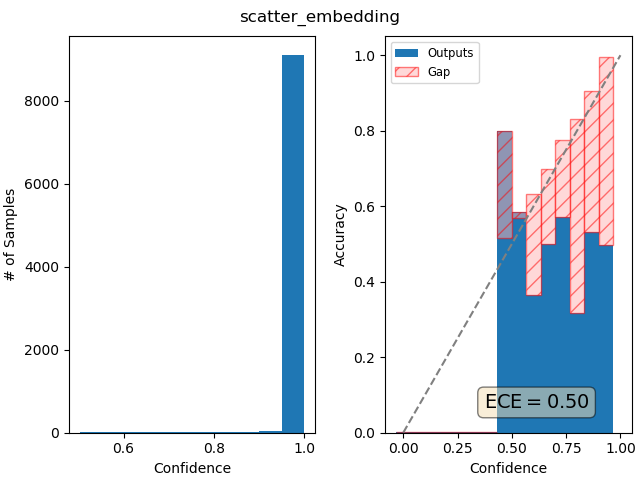
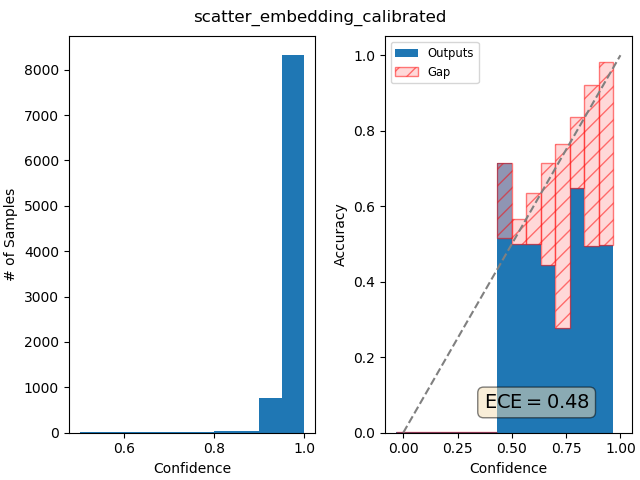
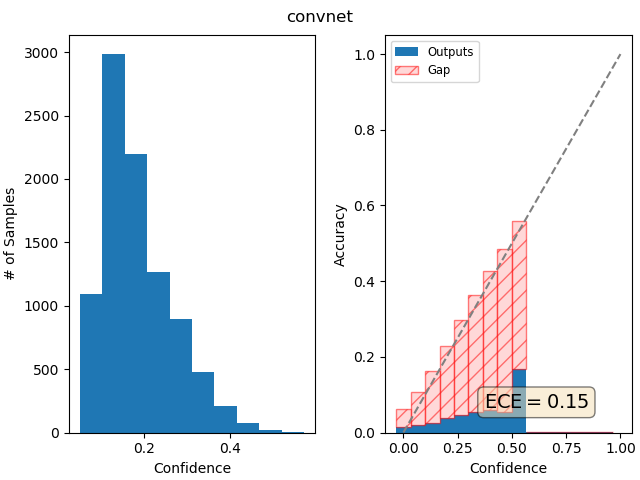
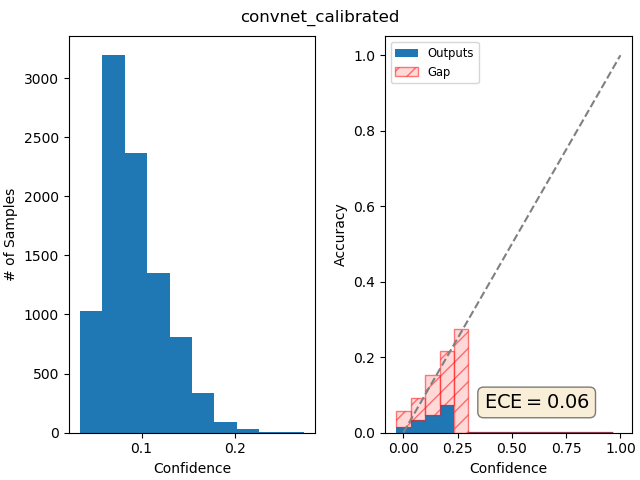
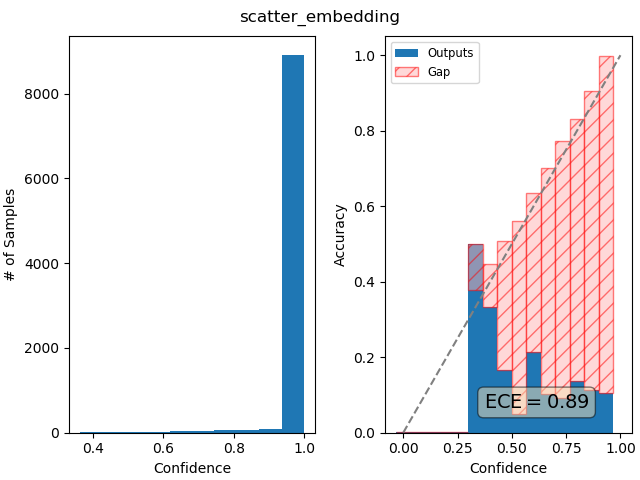
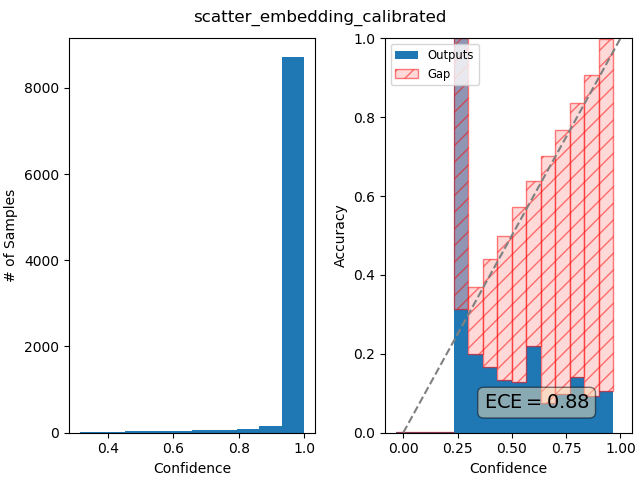
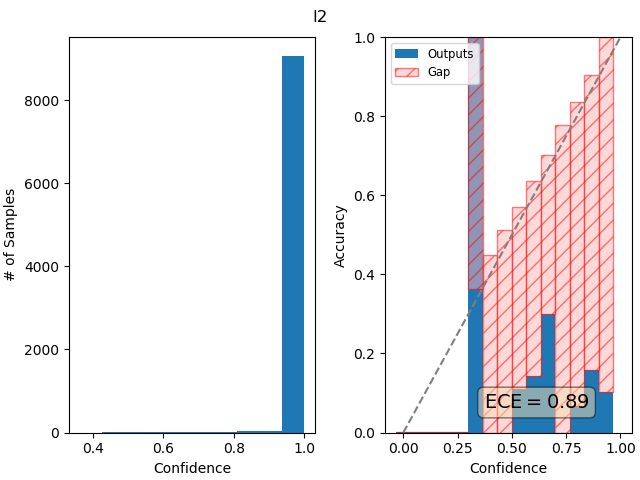
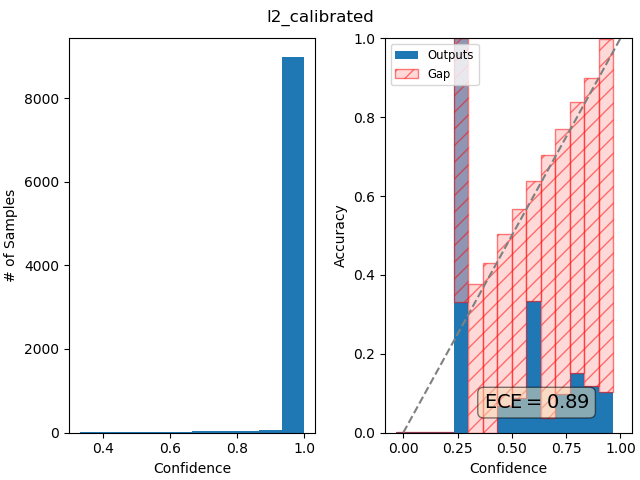
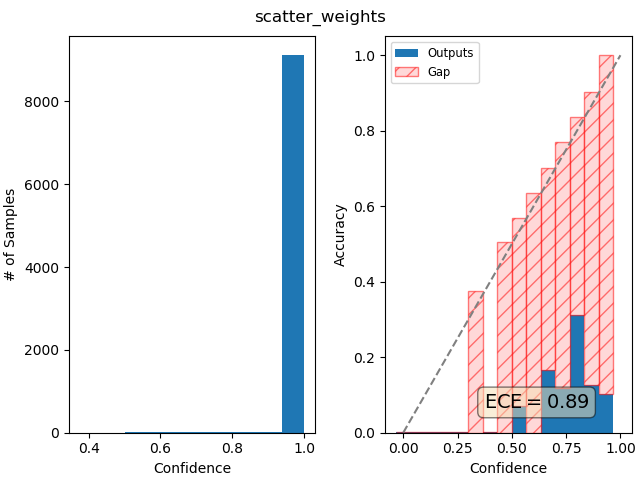
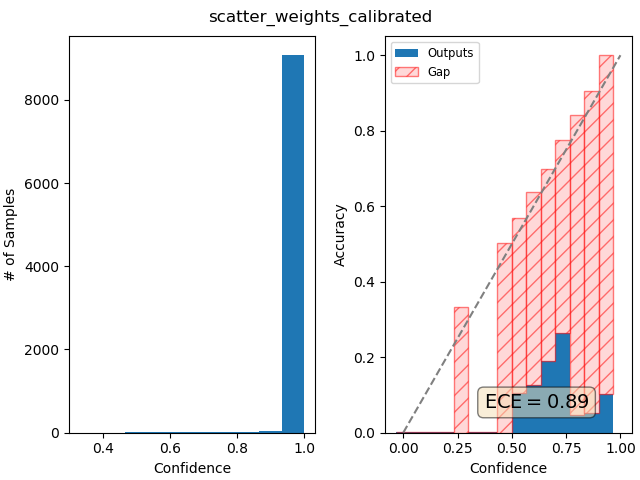
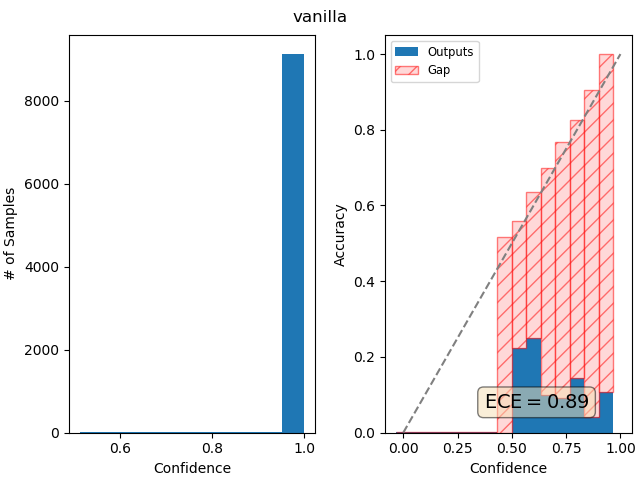
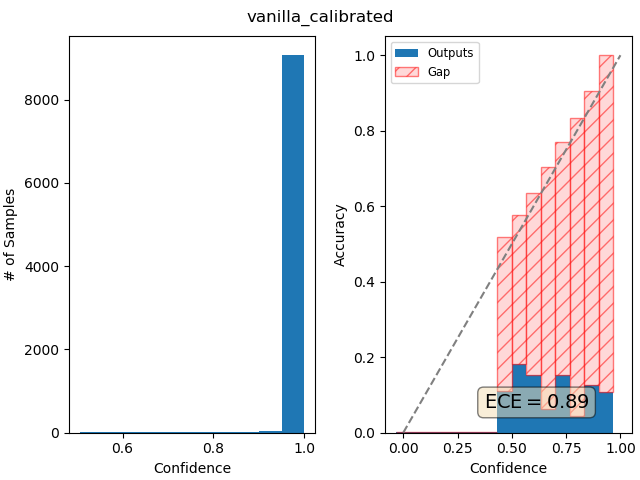
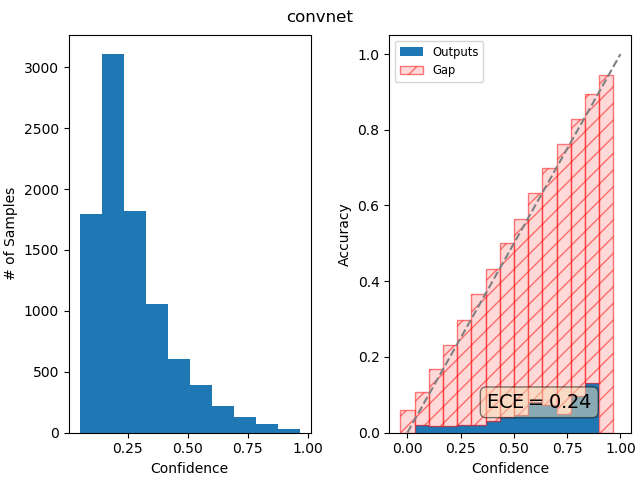
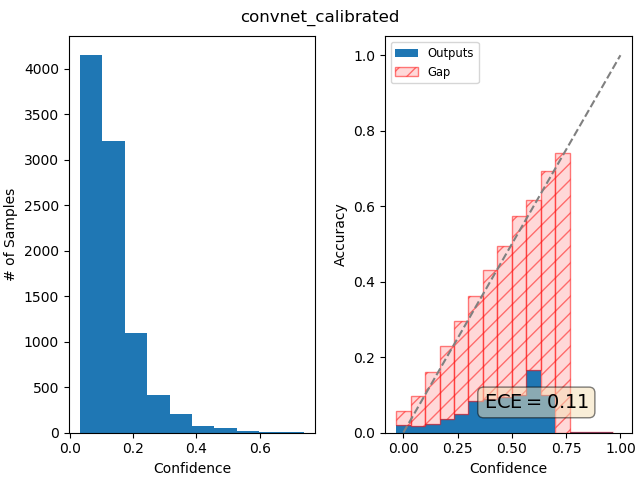
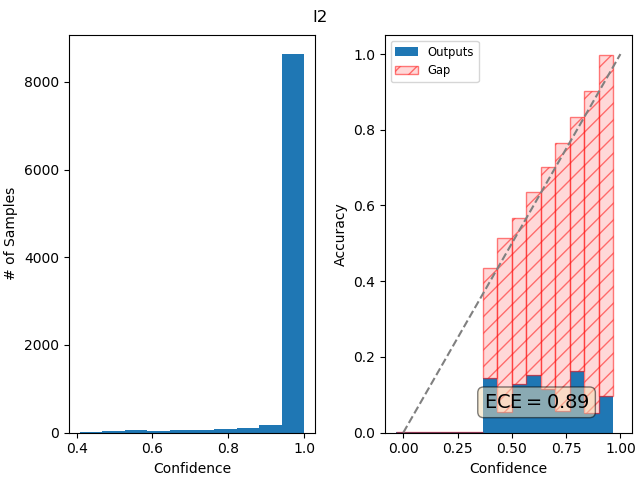
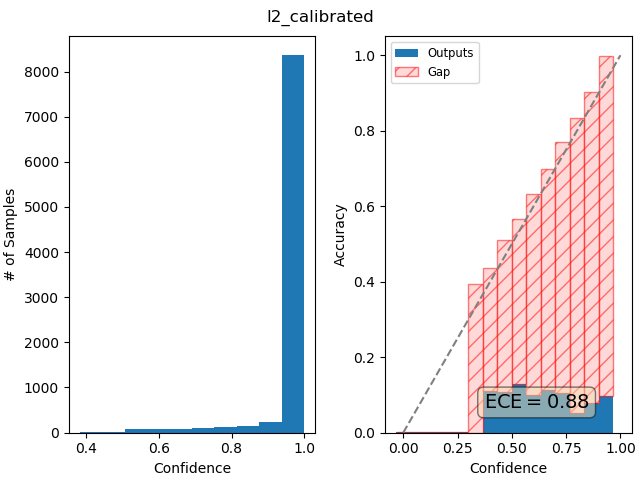
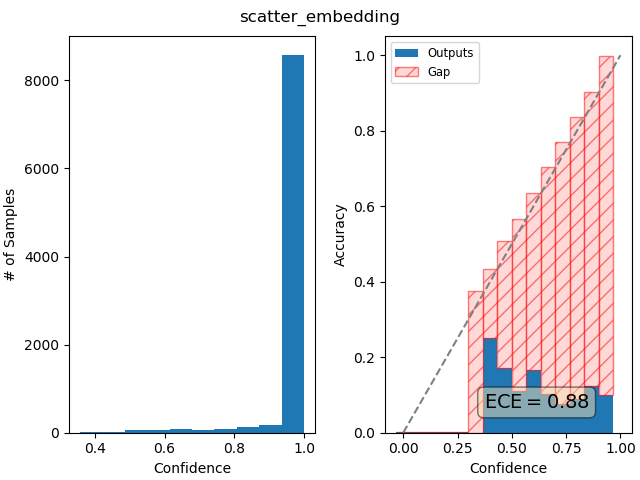
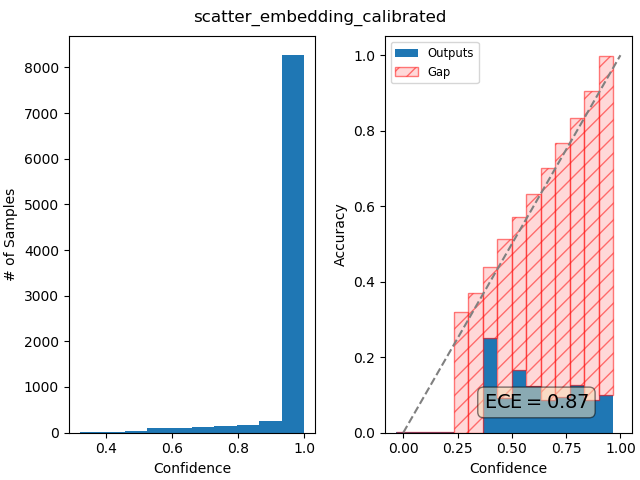
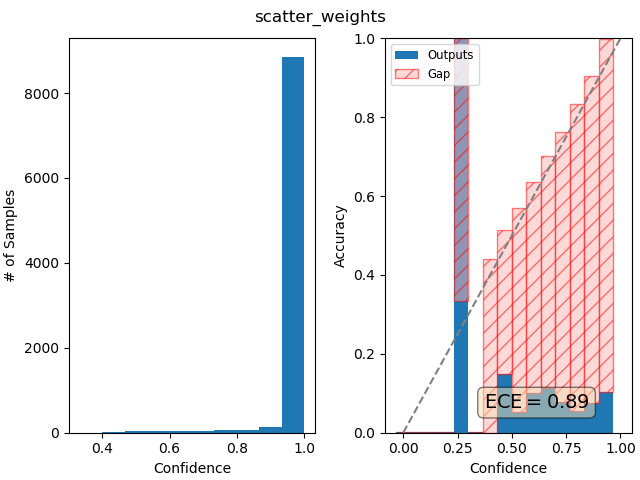
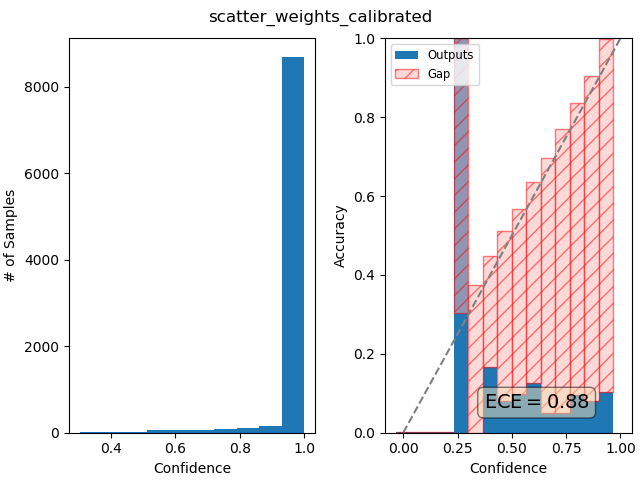
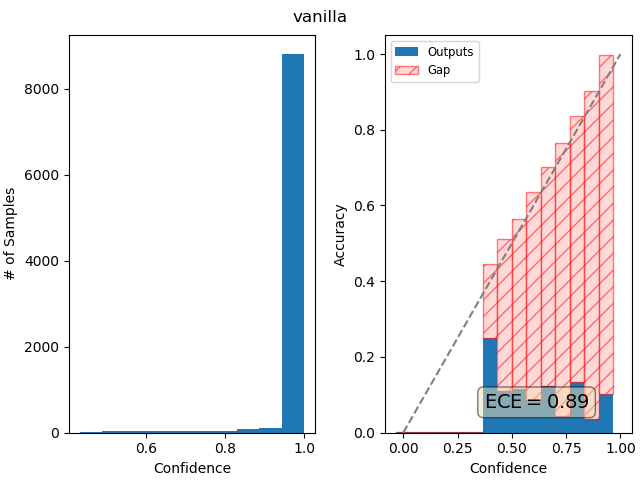
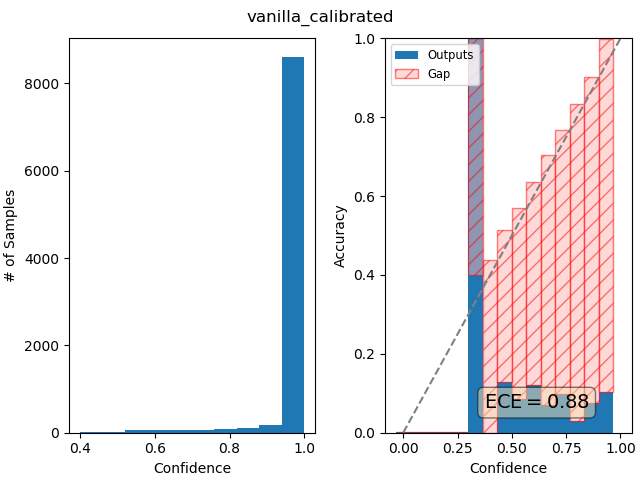
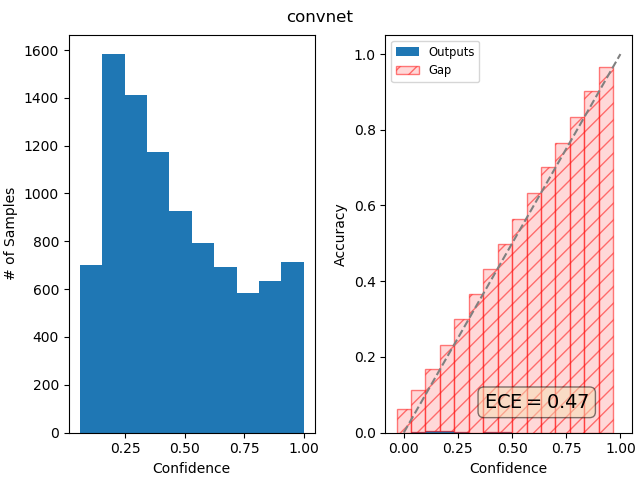
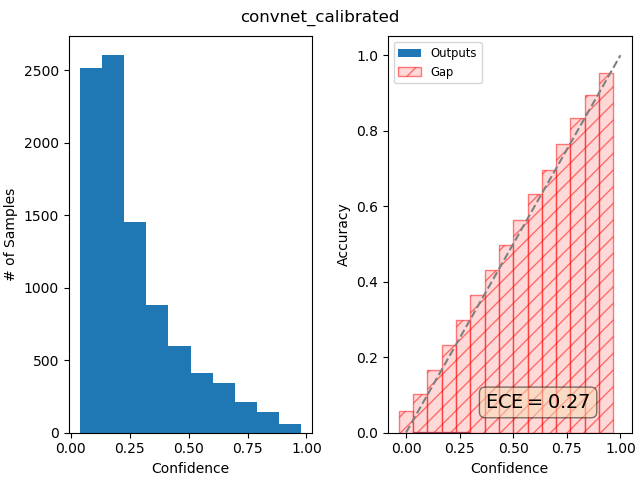
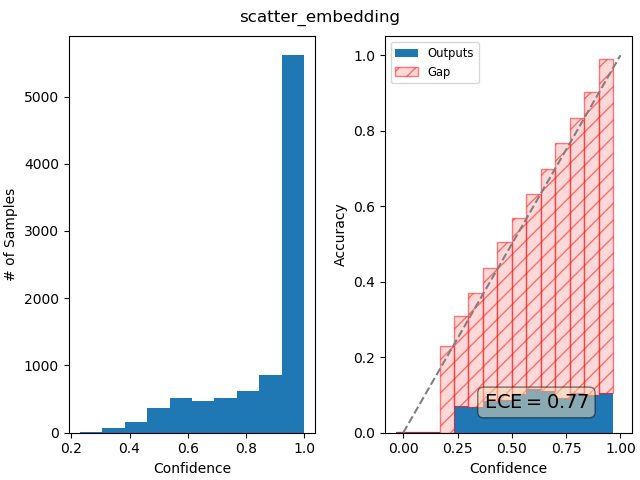
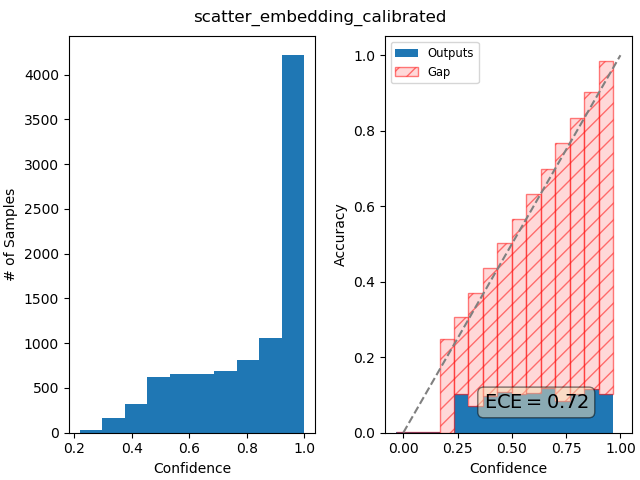
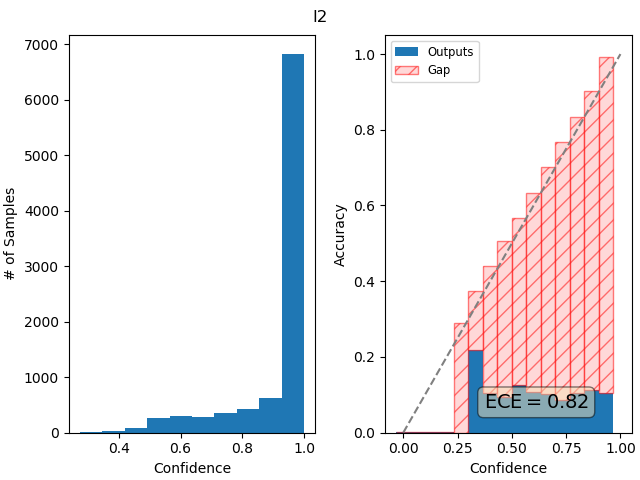
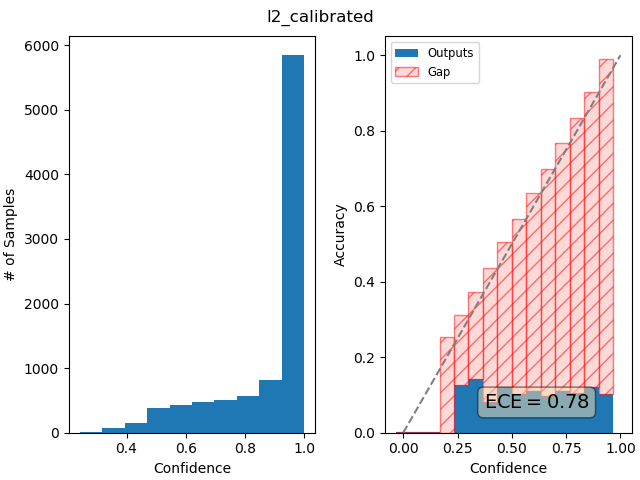
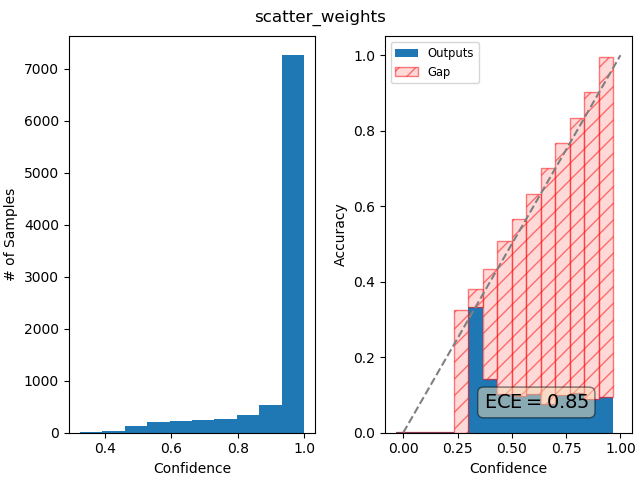
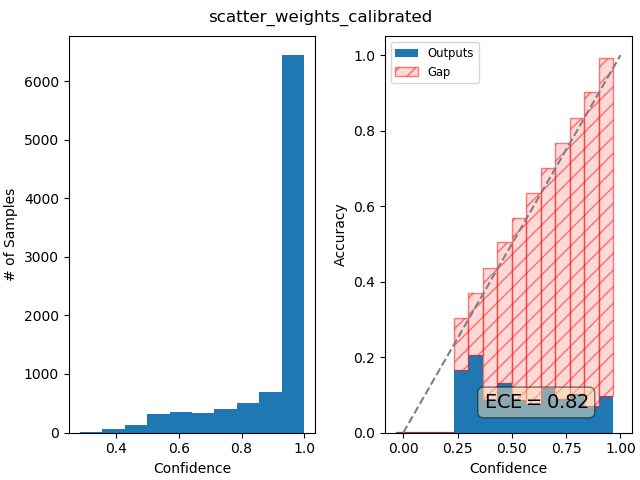
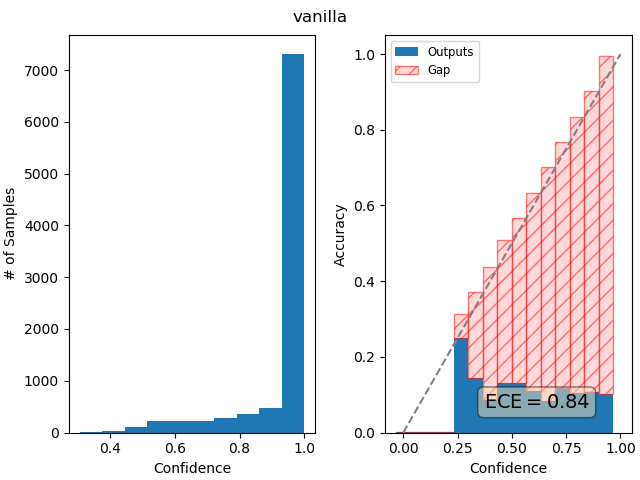
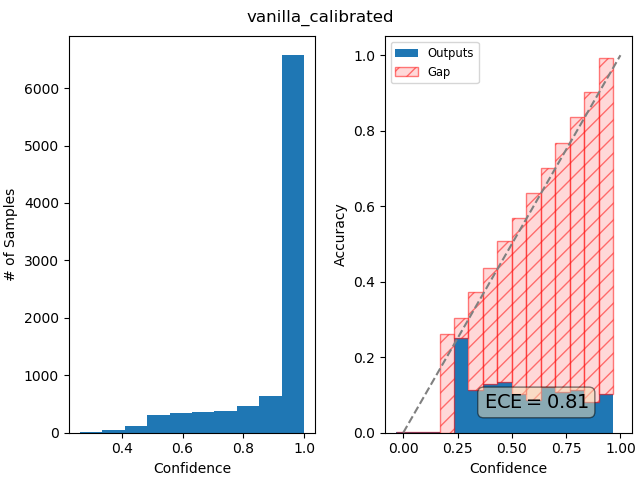

In [63]:
# Show the results for each model and dataset combination
HTML(df_calibrated[['Model', 'Before', 'After']].to_html(formatters={'Before': image_formatter, 'After': image_formatter}, escape=False))